In [85]:
import os
import numpy as np
from skimage import io, measure
import re
import pandas as pd

In [86]:
class InvalidPointError(Exception):
    pass

def process_image(image_path):
    image = io.imread(image_path)

    binary_image = image > 0
    height, width = binary_image.shape

    # Identify bottom-most pixel on the left half of the shape
    left_half = binary_image[:, :width//2]
    bottom_left_y, bottom_left_x = np.argwhere(left_half)[-1]

    # Identify bottom-most pixel on the right half of the shape
    right_half = binary_image[:, width//2:]
    bottom_right_y, bottom_right_x = np.argwhere(right_half)[-1]
    bottom_right_x += width // 2  

    # Trace Bottom Border
    bottom_border_trace = []
    for x in range(bottom_left_x, bottom_right_x + 1):
        column = np.argwhere(binary_image[:, x])
        if column.size > 0:
            y = column[-1, 0]
            bottom_border_trace.append((x, y))

    # Identify the apex
    bottom_border_trace = np.array(bottom_border_trace)
    apex_index = np.argmin(bottom_border_trace[:, 1])
    apex = bottom_border_trace[apex_index]

    # Divide the image into two halves at the apex point
    apex_x = apex[0]

    # For the left half, get the rightmost pixel in each row
    left_half_pixels = []
    for y in range(height):
        row = np.argwhere(binary_image[y, :apex_x])
        if row.size > 0:
            left_half_pixels.append((row[-1, 0], y))

    # For the right half, get the leftmost pixel in each row
    right_half_pixels = []
    for y in range(height):
        row = np.argwhere(binary_image[y, apex_x:])
        if row.size > 0:
            right_half_pixels.append((row[0, 0] + apex_x, y))

    # Combine
    new_image = np.zeros_like(binary_image)

    inner_boundary = []

    for x, y in left_half_pixels + right_half_pixels:
        if y >= apex[1]:
            new_image[y, x] = 1
            inner_boundary.append((x, y))

    new_image[apex[1], apex[0]] = 1
    new_image[bottom_left_y, bottom_left_x] = 1
    new_image[bottom_right_y, bottom_right_x] = 1

    inner_boundary.append((apex[0], apex[1]))
    inner_boundary.append((bottom_left_x, bottom_left_y))
    inner_boundary.append((bottom_left_x, bottom_left_y))
    
    # Calculate R and L
    R = bottom_right_y - apex[1]
    L = bottom_left_y - apex[1]
    
    # Identify section end-points S1, S2, S3, S5, S6, S7
    S1 = next((point for point in inner_boundary if point[0] < apex[0] and point[1] == bottom_left_y - 2 * L // 7), None)
    S2 = next((point for point in inner_boundary if point[0] < apex[0] and point[1] == bottom_left_y - 4 * L // 7), None)
    S3 = next((point for point in inner_boundary if point[0] < apex[0] and point[1] == bottom_left_y - 6 * L // 7), None)
    S7 = next((point for point in inner_boundary if point[0] > apex[0] and point[1] == bottom_right_y - 2 * R // 7), None)
    S6 = next((point for point in inner_boundary if point[0] > apex[0] and point[1] == bottom_right_y - 4 * R // 7), None)
    S5 = next((point for point in inner_boundary if point[0] > apex[0] and point[1] == bottom_right_y - 6 * R // 7), None)
    
    # Get N equally spaced pixels in each section
    N = 10
    left_length = (2 * L // 7) // N
    right_length = (2 * R // 7) // N

    segment1 = []
    segment2 = []
    segment3 = []
    segment7 = []
    segment6 = []
    segment5 = []

    def get_leftside_N_points(bottom_point):
        points = []
        for i in range(N):
            point = next((point for point in inner_boundary if point[0] < apex[0] and point[1] == (bottom_point[1] - ((i + 1) * left_length))), None)
            points.append(point)
        return points

    def get_rightside_N_points(bottom_point):
        points = []
        for i in range(N):
            point = next((point for point in inner_boundary if point[0] > apex[0] and point[1] == (bottom_point[1] - ((i + 1) * right_length))), None)
            points.append(point)
        return points

    segment1 = get_leftside_N_points((bottom_left_x, bottom_left_y))
    segment2 = get_leftside_N_points(S1)
    segment3 = get_leftside_N_points(S2)

    segment7 = get_rightside_N_points((bottom_right_x, bottom_right_y))
    segment6 = get_rightside_N_points(S7)
    segment5 = get_rightside_N_points(S6)
    
    return {
        'segment1': segment1,
        'segment2': segment2,
        'segment3': segment3,
        'segment7': segment7,
        'segment6': segment6,
        'segment5': segment5
    }

def calculate_manhattan_distance(p1, p2):
    if p1 is None or p2 is None:
        raise InvalidPointError
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

def process_images_in_directory(directory_path):
    results = {}
    
    def extract_frame_number(filename):
        match = re.search(r'\d+', filename)
        return int(match.group()) if match else -1
    
    filenames = sorted([f for f in os.listdir(directory_path) if f.endswith(".png")], key=extract_frame_number)
    
    first_frame_segments = None
    
    for idx, filename in enumerate(filenames):
        image_path = os.path.join(directory_path, filename)
        segments = process_image(image_path)
        
        if idx == 0:
            first_frame_segments = segments
        else:
            mean_manhattan_distances = {}
            for segment_name, segment in segments.items():
                displacements = [
                    calculate_manhattan_distance(first_frame_segments[segment_name][i], segment[i]) 
                    for i in range(len(segment))
                ]
                displacements = [d for d in displacements if d is not None]
                mean_manhattan_distances[segment_name] = np.mean(displacements) if displacements else None
            results[filename] = mean_manhattan_distances
    
    return results

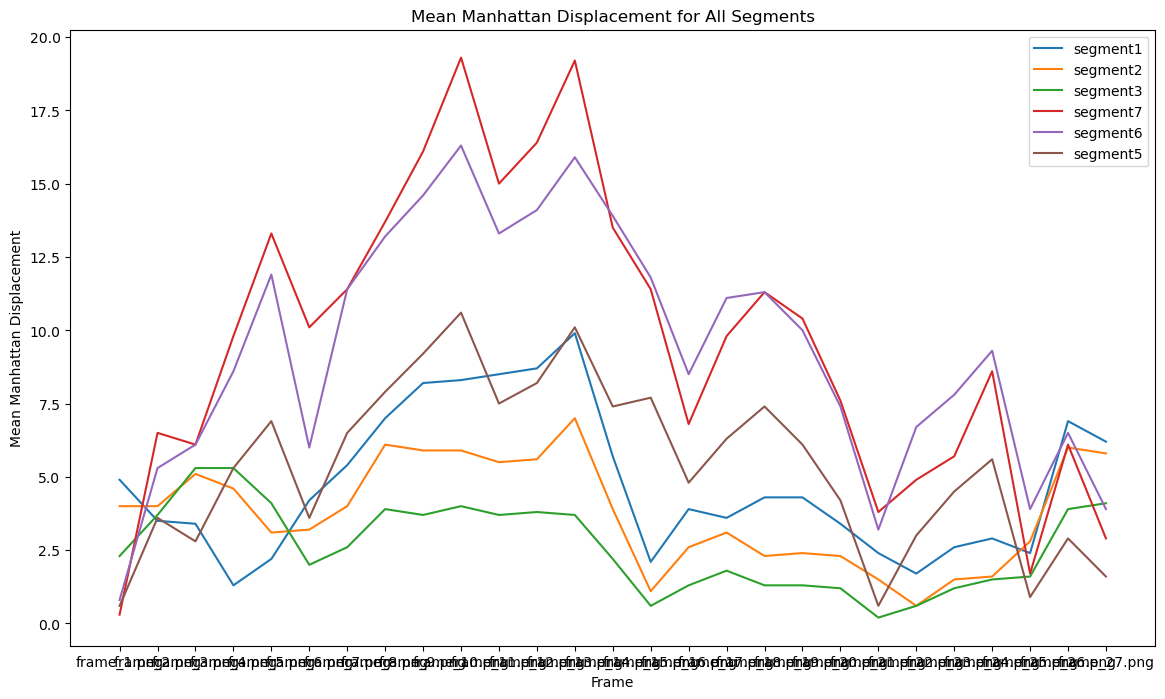

In [105]:
import matplotlib.pyplot as plt

def plot_mean_manhattan_distances(results):
    segments = list(results[next(iter(results))].keys())
    frames = list(results.keys())
    
    plt.figure(figsize=(14, 8))
    
    for segment in segments:
        mean_distances = [results[frame][segment] for frame in frames]
        plt.plot(frames, mean_distances, label=segment)
        
    plt.xlabel('Frame')
    plt.ylabel('Mean Manhattan Displacement')
    plt.title('Mean Manhattan Displacement for All Segments')
    plt.legend()
    plt.show()
        
directory_path = r"C:\Users\noorh\Echocardiograms\mats\Mask_ES00020 _4CH_1"
results = process_images_in_directory(directory_path)
plot_mean_manhattan_distances(results)

In [100]:
def get_displacement_peaks(results):
    max_displacements = {segment: 0 for segment in next(iter(results.values())).keys()}
    
    for pair_name, segments in results.items():
        for segment, distance in segments.items():
            if distance is not None:
                if distance > max_displacements[segment]:
                    max_displacements[segment] = distance
    
    # Normalize the max displacements to unity
    #max_value = max(max_displacements.values())
    #motion_feature = {segment: value / max_value for segment, value in max_displacements.items()}
    
    return max_displacements

max_displacements = get_displacement_peaks(results)
max_displacements

{'segment1': 9.9,
 'segment2': 7.0,
 'segment3': 5.3,
 'segment7': 19.3,
 'segment6': 16.3,
 'segment5': 10.6}

In [101]:
def process_all_directories(parent_directory):
    all_motion_features = []

    for subdir in os.listdir(parent_directory):
        subdir_path = os.path.join(parent_directory, subdir)
        if os.path.isdir(subdir_path):
            try:
                results = process_images_in_directory(subdir_path)
                motion_feature = get_displacement_peaks(results)
                motion_feature['subdirectory'] = subdir
                all_motion_features.append(motion_feature)
            except InvalidPointError:
                print(f"Invalid point found in directory: {subdir}")
                break

    return all_motion_features

def save_to_excel(data, output_file):
    df = pd.DataFrame(data)
    df.to_excel(output_file, index=False)

# Main directory containing all subdirectories
parent_directory = r"C:\Users\noorh\Echocardiograms\mats"
output_file = r"C:\Users\noorh\Echocardiograms\Final Submission\motion_features.xlsx"

all_motion_features = process_all_directories(parent_directory)
save_to_excel(all_motion_features, output_file)

print(f"Motion features saved to {output_file}")

Motion features saved to C:\Users\noorh\Echocardiograms\Final Submission\motion_features_normalized_column.xlsx
